In [ ]:
! pip install datasets

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from typing import Tuple, Optional
import math
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from transformers import get_linear_schedule_with_warmup

In [ ]:
class ModelArgs:
    def __init__(
        self,
        dim: int,
        n_layers: int,
        head_dim: int,
        hidden_dim: int,
        n_heads: int,
        n_kv_heads: int,
        norm_eps: float,
        vocab_size: int,
        rope_theta: float = 10000,
    ):
        self.dim = dim
        self.n_layers = n_layers
        self.head_dim = head_dim
        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.n_kv_heads = n_kv_heads
        self.norm_eps = norm_eps
        self.vocab_size = vocab_size
        self.rope_theta = rope_theta

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, dims: int, eps: float = 1e-5):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dims))
        self.eps = eps

    def _norm(self, x):
        return x * (x.square().mean(-1, keepdim=True) + self.eps).rsqrt()

    def forward(self, x):
        output = self._norm(x.float()).type(x.dtype)
        return self.weight * output


In [ ]:
class FeedForward(nn.Module):
    def __init__(self, args: "ModelArgs"):
        super().__init__()

        self.w1 = nn.Linear(args.dim, args.hidden_dim, bias=False)
        self.w2 = nn.Linear(args.hidden_dim, args.dim, bias=False)
        self.w3 = nn.Linear(args.dim, args.hidden_dim, bias=False)

    def forward(self, x) -> torch.Tensor:
        return self.w2(F.silu(self.w1(x)) * self.w3(x))

In [ ]:
class RoPE(nn.Module):
    def __init__(self, dim: int, traditional: bool = False, base: float = 10000.0):
        super().__init__()
        self.dim = dim
        self.traditional = traditional
        self.base = base
        self.freqs = self.create_freqs(dim // 2)

    def create_freqs(self, n: int):
        freqs = 1.0 / (self.base ** (torch.arange(0, n, 2) / n))
        return freqs

    def forward(self, x: torch.Tensor, offset: int = 0):
        if self.traditional:
            t = torch.arange(x.shape[2], device=x.device) + offset
        else:
            t = torch.arange(x.shape[2], device=x.device)
        freqs = self.freqs.to(x.device)
        t_sin = torch.sin(t[:, None] * freqs[None, :])
        t_cos = torch.cos(t[:, None] * freqs[None, :])
        return torch.stack([x[..., 0::2] * t_cos + x[..., 1::2] * t_sin,
                           x[..., 0::2] * t_sin - x[..., 1::2] * t_cos], dim=-1).flatten(-2, -1)

In [ ]:
class Attention(nn.Module):
    def __init__(self, args: "ModelArgs"):
        super().__init__()
        self.args = args

        self.n_heads: int = args.n_heads
        self.n_kv_heads: int = args.n_kv_heads

        self.repeats = self.n_heads // self.n_kv_heads

        self.scale = self.args.head_dim**-0.5

        self.wq = nn.Linear(args.dim, args.n_heads * args.head_dim, bias=False)
        self.wk = nn.Linear(args.dim, args.n_kv_heads * args.head_dim, bias=False)
        self.wv = nn.Linear(args.dim, args.n_kv_heads * args.head_dim, bias=False)
        self.wo = nn.Linear(args.n_heads * args.head_dim, args.dim, bias=False)
        self.rope = RoPE(args.head_dim, traditional=True)

    def forward(
        self,
        x: torch.Tensor,
        mask: Optional[torch.Tensor] = None,
        cache: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,
    ) -> torch.Tensor:
        B, L, D = x.shape

        queries, keys, values = self.wq(x), self.wk(x), self.wv(x)

        # Prepare the queries, keys and values for the attention computation
        queries = queries.view(B, L, self.n_heads, -1).transpose(1, 2)
        keys = keys.view(B, L, self.n_kv_heads, -1).transpose(1, 2)
        values = values.view(B, L, self.n_kv_heads, -1).transpose(1, 2)

        def repeat(a):
            a = torch.cat([a.unsqueeze(2)] * self.repeats, dim=2)
            return a.view([B, self.n_heads, L, -1])

        keys, values = map(repeat, (keys, values))

        # Rolling Buffer Cache
        if cache is not None:
            key_cache, value_cache = cache
            queries = self.rope(queries, offset=key_cache.shape[2])
            keys = self.rope(keys, offset=key_cache.shape[2])
            keys = torch.cat([key_cache, keys], dim=2)
            values = torch.cat([value_cache, values], dim=2)
        else:
            queries = self.rope(queries)
            keys = self.rope(keys)

        scores = (queries * self.scale) @ keys.transpose(-1, -2)
        if mask is not None:
            scores += mask
        scores = F.softmax(scores.float(), dim=-1).type(scores.dtype)
        output = (scores @ values).transpose(1, 2).contiguous().view(B, L, -1)
        return self.wo(output), (keys, values)

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, args: "ModelArgs"):
        super().__init__()
        self.n_heads = args.n_heads
        self.dim = args.dim
        self.attention = Attention(args)
        self.feed_forward = FeedForward(args=args)
        self.attention_norm = RMSNorm(args.dim, eps=args.norm_eps)
        self.ffn_norm = RMSNorm(args.dim, eps=args.norm_eps)
        self.args = args

    def forward(
        self,
        x: torch.Tensor,
        mask: Optional[torch.Tensor] = None,
        cache: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,
    ) -> torch.Tensor:
        r, cache = self.attention(self.attention_norm(x), mask, cache)
        h = x + r
        r = self.feed_forward(self.ffn_norm(h))
        out = h + r
        return out, cache

In [ ]:
class Mistral(nn.Module):
    def __init__(self, args: "ModelArgs"):
        super().__init__()
        self.args = args
        self.vocab_size = args.vocab_size
        self.n_layers = args.n_layers
        assert self.vocab_size > 0
        self.tok_embeddings = nn.Embedding(args.vocab_size, args.dim)
        self.layers = nn.ModuleList([TransformerBlock(args=args) for _ in range(args.n_layers)])
        self.norm = RMSNorm(args.dim, eps=args.norm_eps)
        self.output = nn.Linear(args.dim, args.vocab_size, bias=False)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.xavier_uniform_(module.weight)
        elif isinstance(module, RMSNorm):
            nn.init.ones_(module.weight)
        elif isinstance(module, nn.MultiheadAttention):
            nn.init.xavier_uniform_(module.in_proj_weight)
            if module.in_proj_bias is not None:
                nn.init.zeros_(module.in_proj_bias)
            nn.init.xavier_uniform_(module.out_proj.weight)
            if module.out_proj.bias is not None:
                nn.init.zeros_(module.out_proj.bias)

    def _generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
        return mask

    def forward(
        self,
        inputs: torch.Tensor,
        cache=None,
    ):
        h = self.tok_embeddings(inputs)

        mask = None
        if h.shape[1] > 1:
            mask = self._generate_square_subsequent_mask(h.shape[1]).to(h.device)

        if cache is None:
            cache = [None] * len(self.layers)

        for e, layer in enumerate(self.layers):
            h, cache[e] = layer(h, mask, cache[e])

        return self.output(self.norm(h)), cache

In [ ]:
"""
{
  "architectures": [
    "MistralForCausalLM"
  ],
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "rms_norm_eps": 1e-05,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.34.0.dev0",
  "use_cache": true,
  "vocab_size": 32000
}
"""

In [ ]:
# Define model hyperparameters
model_args = ModelArgs(
    dim=4096,            # Embedding dimension
    n_layers=4,        # Number of Transformer layers
    head_dim=128,         # Head dimension for multi-head attention
    hidden_dim=14336,    # Dimension of hidden layer in the feedforward network
    n_heads=32,          # Number of attention heads
    n_kv_heads=32,       # Number of key/value heads (can be different from n_heads)
    norm_eps=1e-5,      # Epsilon value for normalization
    vocab_size=32000,   # Size of your vocabulary
    rope_theta=10000,   # Base value for Rotary Position Embeddings
)

# Create the Mistral model
model = Mistral(model_args)

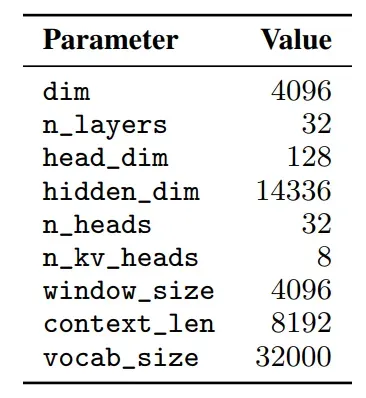

In [ ]:
model

Mistral(
  (tok_embeddings): Embedding(50257, 768)
  (layers): ModuleList(
    (0-11): 12 x TransformerBlock(
      (attention): Attention(
        (wq): Linear(in_features=768, out_features=16, bias=False)
        (wk): Linear(in_features=768, out_features=16, bias=False)
        (wv): Linear(in_features=768, out_features=16, bias=False)
        (wo): Linear(in_features=16, out_features=768, bias=False)
        (rope): RoPE()
      )
      (feed_forward): FeedForward(
        (w1): Linear(in_features=768, out_features=3072, bias=False)
        (w2): Linear(in_features=3072, out_features=768, bias=False)
        (w3): Linear(in_features=768, out_features=3072, bias=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
# Function to get training data
def get_training_corpus():
    dataset = load_dataset("text", data_files={"train": "/content/cleaned_data.txt"})
    for i in range(0, len(dataset["train"]), 1000):
        yield dataset["train"][i : i + 1000]["text"]


# Load the base tokenizer
base_tokenizer = AutoTokenizer.from_pretrained("unsloth/mistral-7b-v0.3-bnb-4bit")

# Train the new tokenizer
new_tokenizer = base_tokenizer.train_new_from_iterator(get_training_corpus(), vocab_size=1000)

# Save the new tokenizer
new_tokenizer.save_pretrained("new_tokenizer")

# Test the new tokenizer
test_text = "The First day"
encoded = new_tokenizer.encode(test_text)
decoded = new_tokenizer.decode(encoded)

print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")

In [ ]:
# Add padding token if it doesn't exist
if new_tokenizer.pad_token is None:
    new_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Ensure pad_token_id is valid
if new_tokenizer.pad_token_id is None or new_tokenizer.pad_token_id >= new_tokenizer.vocab_size:
    new_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    new_tokenizer.pad_token_id = new_tokenizer.vocab_size - 1  # Use the last valid token ID as padding

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class TextDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.max_length = max_length
        with open(file_path, 'r', encoding='utf-8') as f:
            self.texts = f.readlines()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True,
                                  padding='max_length',
                                  max_length=self.max_length,
                                  return_tensors='pt') # Ensure PyTorch Tensor output

        input_ids = encoding['input_ids'].squeeze()

        # Assuming you want to use the input_ids as labels for language modeling

        # Shift labels
        labels = input_ids.clone()

        labels[:-1] = input_ids[1:]  # Shift labels
        return input_ids, labels  # Return both input_ids and labels

In [ ]:
import time
from tqdm import tqdm
def train(model: Mistral,
          train_data: DataLoader,
          val_data: DataLoader,
          optimizer: torch.optim.Optimizer,
          epochs: int = 10,
          device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
          clip_grad_norm: float = 1.0,
          lr_scheduler=None):
    """Trains the Mistral model.

    Args:
        model: The Mistral model to train.
        train_data: A DataLoader for the training dataset.
        optimizer: The optimizer to use for training.
        epochs: The number of training epochs.
        device: The device to use for training (e.g., 'cuda' or 'cpu').
        clip_grad_norm: The maximum norm of the gradients to clip.
        lr_scheduler: An optional learning rate scheduler.
    """

    model = model.to(device)
    model.train()

    print("Training...")
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        total_loss = 0.0
        start_time = time.time()

        for batch in tqdm(train_data, leave=False):
            input_ids, labels = batch

            input_ids, labels = input_ids.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs, _ = model(input_ids)

            # Calculate loss (use cross-entropy loss for language modeling)
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(outputs.view(-1, model.vocab_size), labels.view(-1))

            # Backward pass
            loss.backward()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)

            # Update weights
            optimizer.step()

            if lr_scheduler is not None:
                lr_scheduler.step(loss.detach().item())

            total_loss += loss.item()


        avg_loss = total_loss / len(train_data)
        elapsed_time = time.time() - start_time
        print(f"Average loss: {avg_loss:.4f} | Elapsed time: {elapsed_time:.2f}s")


        # Evaluation Phase
        model.eval()
        eval_loss = 0
        with torch.no_grad():
            for step, batch in enumerate(val_data):
                # Get input_ids and labels from the batch
                input_ids, labels = batch
                input_ids = input_ids.to(device)  # Send input_ids to the device
                labels = labels.to(device)  # Send labels to the device

                # Forward pass
                outputs, _ = model(input_ids)

                # Calculate loss
                loss = F.cross_entropy(outputs.view(-1, model.vocab_size), labels.view(-1), ignore_index=new_tokenizer.pad_token_id)
                eval_loss += loss.item()
        avg_eval_loss = eval_loss / len(val_data)
        print(f"Epoch: {epoch+1}, Evaluation Loss: {avg_eval_loss:.4f}")
    model_save_path = "mistral.pt"
    torch.save(model.state_dict(), model_save_path)
    print("Training complete!")

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

In [ ]:
# Create dataset and dataloaders
train_dataset = TextDataset('/content/cleaned_data.txt',
                            new_tokenizer,
                            max_length=512)
train_loader = DataLoader(train_dataset,
                          batch_size=4,
                          shuffle=False)

In [ ]:
# Create dataset and dataloaders
val_dataset = TextDataset('/content/validation.txt',
                            new_tokenizer,
                            max_length=512)
val_loader = DataLoader(val_dataset,
                          batch_size=4,
                          shuffle=False)

In [ ]:
train(model ,
      train_loader,
      val_loader,
      optimizer,
      epochs=1,
      device=device,
      clip_grad_norm=1.0,
      lr_scheduler=lr_scheduler)

Training...
Epoch 1/1


Average loss: 0.6468 | Elapsed time: 384.01s
Epoch: 1, Evaluation Loss: 6.6636
Training complete!


In [ ]:
max_length = 30
num_return_sequences = 10


tokens = new_tokenizer.encode("I'm a ")
tokens = torch.tensor(tokens , dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)

x = tokens.to(device)

while x.size(1) < max_length:

    with torch.no_grad():
        outputs = model(x)
        logits = outputs[0] if isinstance(outputs, tuple) else outputs
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)

        ix = torch.multinomial(topk_probs, 1)
        xcol = torch.gather(topk_indices, -1, ix)
        x = torch.cat((x, xcol), dim=1)

# print the generated text
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    decoded = new_tokenizer.decode(tokens, skip_special_tokens=True)
    print(">", decoded)